<a href="https://colab.research.google.com/github/Mongeese1/phyiscs-big-data/blob/master/This_One_Chad_Exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The GetPlanetData function searches nexsci and tess data for any exoplanet that you input into it and outputs a light curve, folded light curve as well as performing an FFI cutout and displaying the first image. Input for function must have " " around it.



Good examples are: DS Tuc A b, wasp-18 b , hat-p-24 b. DS Tuc A b is a good example of a planet that is not in the exoplanets.org catalogue, however my function simply uses the nexcsi catalogue instead, if it sees that the planet is not on exoplanets.org .
The function returns errors if planet is not in tess catalogue, for example K2-22 b.
It also prints errors if planet mass or solar mass data are unavailable, however it should produce lightcurve/ffi image assuming they are available
Some exoplanets(KELT-11 b) produce a low quality FFI image, unfortunatley this is out of my control.
It also should, though untested, produce an error if the planet is not in the nexsci catalogue, however i have been unable to find an example of such. Any commented out code provides unecessary information, however it is useful for troubleshooting.




Something broke the code today. Not astroquery, likely something internal with database. Means that code is unable to retrieve host star data. Previously it would display an FFI cutout of the first image with host star and other nearby bright stars marked. The lightcurve stuff still works, error is in 

Or not. Some database must have gone down for a bit, all good now. If it doesn't work when you run it, try waiting a bit. Either way [here](https://prnt.sc/r3oyb2) is what it should look like, this is for wasp-18 b 

In [3]:
#imports
#might have to !pip install astroquery or any other errors
!pip install "astroquery ==0.4.dev5744"
%matplotlib inline
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.wcs import WCS
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import requests
import pandas as p
from IPython.display import display, HTML
import zipfile





planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"

urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"
header={}


     |████████████████████████████████| 4.4MB 2.6MB/s 
     |████████████████████████████████| 2.3MB 29.3MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.dev0-cp36-none-any.whl size=3509363 sha256=bdbf4606c05de366cbdb555b8b7508bc7b718791db5fab02e036df5228bb8292
  Stored in directory: /root/.cache/pip/wheels/bc/b7/a7/2150691663ca1e59f76d0568b9a8e0a65ab30e8f37d39aba04
Successfully built astroquery


In [0]:
def GetPlanetData(name):
  #grab planet info 
  planet_name = name

  url = planeturl + "/identifiers/"

  myparams = {"name":planet_name}

  r = requests.get(url = url, params = myparams, headers = header)
  # print(r.headers.get('content-type'))
  #define planet names
  planet_names = r.json()
  ticid = planet_names['tessID']
  tce = planet_names['tessTCE']
  planet_names


  url = planeturl + planet_name + "/properties/"

  r = requests.get(url = url, headers = header)
  #check for server errors retrieving planet data
  try:
    r.json()
  except:
    print('Server error retrieving planet data')
    return
  
  planet_prop = r.json()
  #check if planet in nexsci catalogue
  try:
    planet_prop[0]
  except:
    print('Planet not in nexsci catalogue, data unavailable')
    return

  # if planet_prop[1] is None:
  #   print('Planet not in exoplanet.org catalogue, some data may be unavailable')
  # else:
  #   print("Catalog 2: " + planet_prop[1]['catalog_name'])
  # try:
  #   planet_prop[1]
  # except:
  #   print('Planet not in exoplanets.org catalogue, data unavailable')
  #   return

  print("Catalog: " + planet_prop[0]['catalog_name'])
  
  planet_prop[0].keys()
 #check mass errors
  if planet_prop[0]['Ms'] is None:
    print('Stellar Mass data unavailable')
  else:
    print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )

  if planet_prop[0]['Mp'] is None:
    print(' Planet Mass data unavailable')
  else:
    print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
    print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))
  
  
  print(planet_name, " Properties")
  
  

  url = dvurl + str(ticid) + '/tces/'
  myparams = {"tce" : tce}
  #grab exoplanet sectors
  r = requests.get(url = url, params = myparams, headers = header)
  try:
    r.json
  except:
    print("Server Error retrieving star data")
    return
  sectorInfo = r.json()
  #ERROR HERE FOR HD 202772 A b FIX WITH IF STATEMENT NONE
  
  # isolate largest sector range
  sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
  sectors
  #check whether in TESS catalogue, if not will have no sectors thereby sectors[0] returns error
  try:
    sectors[0]
  except:
    print("Planet not in TESS catalogue, light curve and FFI data unavailable")
    return
  #Get info from TESS
  url = dvurl + str(ticid) + '/info/'
  myparams = {"tce" : tce,
              "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  try:
    r.json()
  except:
    print("Server error grabbing TESS data")
    return
  tceInfo = r.json()
  tceInfo.keys()
  tceInfo['DV Data Header'].keys()

  print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
  print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

  # Grab planet data
  url = dvurl + str(ticid) + '/table/'
  myparams = {"tce" : tce, "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  #check for server errors retrieving star data
  try:
    r.json()
  except:
    print("Server error retrieving star data")
    return
  tce_data = r.json()
  #sort data
  data = p.DataFrame.from_dict(tce_data['data'])
  data.columns
  #define axis for light curve plot
  detrend = data['LC_DETREND']
  model = data['MODEL_INIT']
  time = data['TIME']
  #plot lightcurve
  plt.figure(figsize=(14,4))
  plt.plot(time,detrend,'.',lw=0.4)
  plt.plot(time,model,'r-',lw=0.6)
  plt.xlabel('TIME (BTJD)')
  plt.ylabel('Relative Flux')
  #folded lightcurve data
  url = dvurl + str(ticid) + '/phaseplot/'
  myparams = {"tce" : tce, "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  #print folded lightcurve from tess
  display(HTML(str(r.content.decode('utf-8'))))
  #cone search
  starName = "TIC" + str(ticid)
  radsearch = 3 / 60
  starData = Catalogs.query_object(starName, radius = radsearch, catalog = "TIC")
  #define star search paramaters
  Ra = starData[0]['ra']
  Dec = starData[0]['dec']

  # print( starData[:10]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )
  #filter for relativley bright nearby stars
  averageTmag = []
  for i in range(len(starData)):
    x = starData['Tmag'][i]
    # sus = np.sum(x, dtype=np.float64)
    averageTmag.append(x)
    # for i in range(len(starData)):
    #   average = sum(averageTmag) / len(averageTmag)
  average = sum(averageTmag) / len(averageTmag)
  brightStar = starData['Tmag'] < average
  nearbyBrightStars = list( map( lambda x,y:[x,y], starData[brightStar]['ra'], starData[brightStar]['dec'] ) )
  # print(len(nearbyBrightStars))
  #determine sectors/cameras for star
  urlStar = urlroot + "/sector"

  myparamsStar = {"ra":Ra, "dec":Dec, "radius":"0m"}

  requestDataStar = requests.get(url = urlStar, params = myparamsStar)
  sectors = requestDataStar.json()['results']
  # print(sectors)
  myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px"}

  url = urlroot + "/astrocut"

  r = requests.get(url = url, params = myparams)

  # print(r)
  # print(r.headers.get('content-type'))
  #get ffi cutouts for star
  open('astrocut.zip', 'wb').write(r.content)
  zipRef = zipfile.ZipFile('astrocut.zip','r')
  zipRef.extractall('.')
  zipRef.close()
  cutoutnames = zipRef.namelist()
  # print(cutoutnames)
  files1 = cutoutnames[0]
  # fits.info(files1)
  imageData = fits.open(files1)
  image = imageData[1].data['Flux'][0]
  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(image, origin = 'lower', cmap = plt.cm.viridis, \
  #          vmax = np.percentile(image,95), vmin = np.percentile(image,2))
  
  #produce first image of timeseries, wcs checks for star location and marks it
  wcs = WCS(imageData[2].header)
  

  fig = plt.figure(figsize = (10,10))
  fig.add_subplot(111, projection = wcs)
  plt.imshow(image, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(image,90),\
            vmin = np.percentile(image,6))
  plt.title('First image of FFI time series')

  plt.xlabel('CCD Column', fontsize = 14)
  plt.ylabel('CCD Row', fontsize = 14)
  plt.grid(axis = 'both', color = 'white', ls = 'solid')

  starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
  plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')

  # plot nearby stars created using catalogue call
  nearbyLoc = wcs.all_world2pix(nearbyBrightStars[1:], 0)
  plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'green')
  plt.text(-5,-5,'Star which exoplanet orbits is red', bbox=dict(facecolor='red', alpha=0.5))
  plt.text(10,-5, 'Stars with above average magnitude in search area are green', bbox=dict(facecolor='green',alpha = 0.5))
  # print(requestDataStar.headers.get('content-type'))
  # print(brightStar)
  
  # print(brightStar)
  # HAT-P-30 b



Catalog: nexsci
Stellar Mass 1.010000 M_sun
Planet Mass 1.300000 M_Jupiter
Planet Mass Reference: Benatti et al. 2019
ds tuc a b  Properties
TIC: TIC 410214986
Planet Radius: 8.254507


ConnectionError: ignored

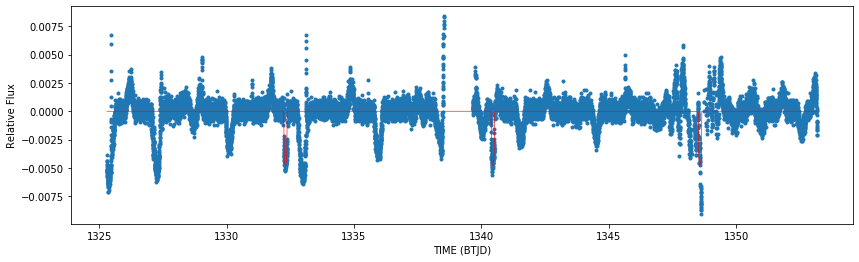

In [11]:
GetPlanetData("ds tuc a b")
# HD 202772 A b